In [16]:
import pandas as pd
import numpy as np
import matplotlib as plt
import collections

import math
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/demouser/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [18]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [20]:
# The (A)NP takes as input a `NPRegressionDescription` namedtuple with fields:
#   `query`: a tuple containing ((context_x, context_y), target_x)
#   `target_y`: a tensor containing the ground truth for the targets to be
#     predicted
#   `num_total_points`: A vector containing a scalar that describes the total
#     number of datapoints used (context + target)
#   `num_context_points`: A vector containing a scalar that describes the number
#     of datapoints used as context
# The GPCurvesReader returns the newly sampled data in this format at each
# iteration

NPRegressionDescription = collections.namedtuple(
    "NPRegressionDescription",
    ("query", "target_y", "num_total_points", "num_context_points"))


class GPCurvesReader(object):
    """Generates curves using a Gaussian Process (GP).

  Supports vector inputs (x) and vector outputs (y). Kernel is
  mean-squared exponential, using the x-value l2 coordinate distance scaled by
  some factor chosen randomly in a range. Outputs are independent gaussian
  processes.
      """

    def __init__(self,
               batch_size,
               max_num_context,
               x_size=1,
               y_size=1,
               l1_scale=0.6,
               sigma_scale=1.0,
               random_kernel_parameters=True,
               testing=False):
        """Creates a regression dataset of functions sampled from a GP.

    Args:
      batch_size: An integer.
      max_num_context: The max number of observations in the context.
      x_size: Integer >= 1 for length of "x values" vector.
      y_size: Integer >= 1 for length of "y values" vector.
      l1_scale: Float; typical scale for kernel distance function.
      sigma_scale: Float; typical scale for variance.
      random_kernel_parameters: If `True`, the kernel parameters (l1 and sigma) 
          will be sampled uniformly within [0.1, l1_scale] and [0.1, sigma_scale].
      testing: Boolean that indicates whether we are testing. If so there are
          more targets for visualization.
        """
        self._batch_size = batch_size
        self._max_num_context = max_num_context
        self._x_size = x_size
        self._y_size = y_size
        self._l1_scale = l1_scale
        self._sigma_scale = sigma_scale
        self._random_kernel_parameters = random_kernel_parameters
        self._testing = testing

    def _gaussian_kernel(self, xdata, l1, sigma_f, sigma_noise=2e-2):
        """Applies the Gaussian kernel to generate curve data.

    Args:
      xdata: Tensor of shape [B, num_total_points, x_size] with
          the values of the x-axis data.
      l1: Tensor of shape [B, y_size, x_size], the scale
          parameter of the Gaussian kernel.
      sigma_f: Tensor of shape [B, y_size], the magnitude
          of the std.
      sigma_noise: Float, std of the noise that we add for stability.

    Returns:
      The kernel, a float tensor of shape
      [B, y_size, num_total_points, num_total_points].
        """
        num_total_points = xdata.shape[1]

    # Expand and take the difference
        xdata1 = xdata.unsqueeze(1)  # [B, 1, num_total_points, x_size]
        xdata2 = xdata.unsqueeze(2)  # [B, num_total_points, 1, x_size]
        diff = xdata1 - xdata2  # [B, num_total_points, num_total_points, x_size]

    # [B, y_size, num_total_points, num_total_points, x_size]
        norm = (diff[:, None, :, :, :] / l1[:, :, None, None, :])**2

        norm = torch.sum(norm, -1)  # [B, data_size, num_total_points, num_total_points]

    # [B, y_size, num_total_points, num_total_points]
        kernel = ((sigma_f)**2)[:, :, None, None] * torch.exp(-0.5 * norm)

    # Add some noise to the diagonal to make the cholesky work.
        kernel += (sigma_noise**2) * torch.eye(num_total_points)

        return kernel

    def generate_curves(self):
        """Builds the op delivering the data.

    Generated functions are `float32` with x values between -2 and 2.
    
    Returns:
      A `CNPRegressionDescription` namedtuple.
        """
        num_context = int(np.random.rand()*(self._max_num_context - 3) + 3)
    # If we are testing we want to have more targets and have them evenly
    # distributed in order to plot the function.
        if self._testing:
            num_target = 400
            num_total_points = num_target
            x_values = torch.arange(-2, 2, 1.0/100).unsqueeze(0).repeat(self._batch_size, 1)
            x_values = x_values.unsqueeze(-1)
    # During training the number of target points and their x-positions are
    # selected at random
        else:
            num_target = int(np.random.rand()*(self._max_num_context - num_context))
            num_total_points = num_context + num_target
            x_values = torch.rand((self._batch_size, num_total_points, self._x_size))*4 - 2
            

    # Set kernel parameters
    # Either choose a set of random parameters for the mini-batch
        if self._random_kernel_parameters:
            l1 = torch.rand((self._batch_size, self._y_size, self._x_size))*(self._l1_scale - 0.1) + 0.1
            sigma_f = torch.rand((self._batch_size, self._y_size))*(self._sigma_scale - 0.1) + 0.1
            
    # Or use the same fixed parameters for all mini-batches
        else:
            l1 = torch.ones((self._batch_size, self._y_size, self._x_size))*self._l1_scale
            sigma_f = torch.ones((self._batch_size, self._y_size))*self._sigma_scale

    # Pass the x_values through the Gaussian kernel
    # [batch_size, y_size, num_total_points, num_total_points]
        kernel = self._gaussian_kernel(x_values, l1, sigma_f)

    # Calculate Cholesky, using double precision for better stability:
        cholesky = torch.cholesky(kernel)

    # Sample a curve
    # [batch_size, y_size, num_total_points, 1]
        y_values = torch.matmul(cholesky, torch.randn((self._batch_size, self._y_size, num_total_points, 1)))

    # [batch_size, num_total_points, y_size]
        y_values = y_values.squeeze(3)
        y_values = y_values.permute(0, 2, 1)

        if self._testing:
      # Select the targets
            target_x = x_values
            target_y = y_values

      # Select the observations
            idx = torch.randperm(num_target)
            context_x = x_values[:, idx[:num_context]]
            context_y = y_values[:, idx[:num_context]]

        else:
      # Select the targets which will consist of the context points as well as
      # some new target points
            target_x = x_values[:, :num_target + num_context, :]
            target_y = y_values[:, :num_target + num_context, :]

      # Select the observations
            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]

        query = ((context_x, context_y), target_x)

        return NPRegressionDescription(
        query=query,
        target_y=target_y,
        num_total_points=target_x.shape[1],
        num_context_points=num_context)


In [21]:
class LatentEncoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim=32, latent_dim=32, self_attention_type="dot", n_encoder_layers=3):
        super(LatentEncoder, self).__init__()
        self._input_layer = nn.Linear(input_dim, hidden_dim)
        self._encoder = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(n_encoder_layers)])
        self._self_attention = Attention(hidden_dim, self_attention_type)
        self._penultimate_layer = nn.Linear(hidden_dim, hidden_dim)
        self._mean = nn.Linear(hidden_dim, latent_dim)
        self._log_var = nn.Linear(hidden_dim, latent_dim)
    def forward(self, x, y):
        encoder_input = torch.cat([x,y], dim=-1)
        
        encoded = self._input_layer(encoder_input)
        
        for layer in self._encoder:
            encoded = torch.relu(layer(encoded))

        attention_output = self._self_attention(encoded, encoded, encoded)
        
        mean_repr = attention_output.mean(dim=1)
        
        mean_repr = torch.relu(self._penultimate_layer(mean_repr))
        
        mean = self._mean(mean_repr)
        log_var = self._log_var(mean_repr)
        
        z = torch.randn_like(log_var)*torch.exp(log_var/2.0) + mean
        
        return z, mean, log_var

In [22]:
class DeterministicEncoder(nn.Module):
    
    def __init__(self, input_dim, x_dim, hidden_dim=32, n_d_encoder_layers=3, self_attention_type="dot",
                 cross_attention_type="dot"):
        super(DeterministicEncoder, self).__init__()
        self._input_layer = nn.Linear(input_dim, hidden_dim)
        self._d_encoder = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(n_d_encoder_layers)])
        self._self_attention = Attention(hidden_dim, self_attention_type)
        self._cross_attention = Attention(hidden_dim, cross_attention_type)
        self._target_transform = nn.Linear(x_dim, hidden_dim)
        self._context_transform = nn.Linear(x_dim, hidden_dim)
    
    def forward(self, context_x, context_y, target_x):
        d_encoder_input = torch.cat([context_x,context_y], dim=-1)
        d_encoded = self._input_layer(d_encoder_input)
        for layer in self._d_encoder:
            d_encoded = torch.relu(layer(d_encoded))
        attention_output = self._self_attention(d_encoded, d_encoded, d_encoded)
        
        q = self._target_transform(target_x)
        k = self._context_transform(context_x)
        q = self._cross_attention(k, d_encoded, q)
        
        return q

In [23]:
class Decoder(nn.Module):
    
    def __init__(self, x_dim, y_dim, hidden_dim=32, latent_dim=32, n_decoder_layers=3):
        super(Decoder, self).__init__()
        self._target_transform = nn.Linear(x_dim, hidden_dim)
        self._decoder = nn.ModuleList([nn.Linear(2*hidden_dim+latent_dim, 2*hidden_dim+latent_dim) for _ in range(n_decoder_layers)])
        self._mean = nn.Linear(2*hidden_dim+latent_dim, y_dim)
        self._std = nn.Linear(2*hidden_dim+latent_dim, y_dim)
        self._softplus = nn.Softplus()
    def forward(self, r, z, target_x):
        x = self._target_transform(target_x)
        
        representation = torch.cat([torch.cat([r, z], dim=-1), x], dim=-1)
        for layer in self._decoder:
            representation = torch.relu(layer(representation))
            
        mean = self._mean(representation)
        std = self._softplus(self._std(representation))
        pred = torch.randn_like(std)*std + mean
        return pred, std

In [24]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, attention_type, n_heads=8):
        super().__init__()
        if attention_type == "uniform":
            self._attention_func = self._uniform_attention
        elif attention_type == "laplace":
            self._attention_func = self._laplace_attention
        elif attention_type == "dot":
            self._attention_func = self._dot_attention
        elif attention_type == "multihead":
            self._W_k = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(n_heads)])
            self._W_v = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(n_heads)])
            self._W_q = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(n_heads)])
            self._W = nn.Linear(n_heads*hidden_dim, hidden_dim)
            self._attention_func = self._multihead_attention
            self.n_heads = n_heads
        else:
            raise NotImplementedError
            
    def forward(self, k, v, q):
        rep = self._attention_func(k, v, q)
        return rep
    
    def _uniform_attention(self, k, v, q):
        total_points = q.shape[1]
        rep = torch.mean(v, dim=1, keepdim=True)
        rep = rep.repeat(1, total_points, 1)
        return rep
    
    def _laplace_attention(self, k, v, q, scale=0.5):
        k_ = k.unsqueeze(1)
        v_ = v.unsqueeze(2)
        unnorm_weights = torch.abs((k_ - v_)*scale)
        unnorm_weights = unnorm_weights.sum(dim=-1)
        weights = torch.softmax(unnorm_weights, dim=-1)
        rep = torch.einsum('bik,bkj->bij', weights, v)
        return rep
    
    def _dot_attention(self, k, v, q):
        scale = q.shape[-1]**0.5
        unnorm_weights = torch.einsum('bjk,bik->bij', k, q) / scale
        weights = torch.softmax(unnorm_weights, dim=-1)
        
        rep = torch.einsum('bik,bkj->bij', weights, v)
        return rep
    
    def _multihead_attention(self, k, v, q):
        outs = []
        for i in range(self.n_heads):
            k_ = self._W_k[i](k)
            v_ = self._W_v[i](v)
            q_ = self._W_q[i](q)
            out = self._dot_attention(k_, v_, q_)
            outs.append(out)
        outs = torch.stack(outs, dim=-1)
        outs = outs.view(outs.shape[0], outs.shape[1], -1)
        rep = self._W(outs)
        return rep

In [25]:
class LatentModel(nn.Module):
    
    def __init__(self, x_dim, y_dim, hidden_dim=32, latent_dim=32, latent_enc_self_attn_type="dot",
                det_enc_self_attn_type="dot", det_enc_cross_attn_type="dot", n_latent_encoder_layers=3,
                n_det_encoder_layers=3, n_decoder_layers=3):
        
        super(LatentModel, self).__init__()
        
        self._latent_encoder = LatentEncoder(x_dim + y_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, 
                                             self_attention_type=latent_enc_self_attn_type,
                                             n_encoder_layers=n_latent_encoder_layers)
        
        self._deterministic_encoder = DeterministicEncoder(x_dim + y_dim, x_dim, hidden_dim=hidden_dim,
                                                           self_attention_type=det_enc_self_attn_type,
                                                           cross_attention_type=det_enc_cross_attn_type,
                                                           n_d_encoder_layers=n_det_encoder_layers)
        
        self._decoder = Decoder(x_dim, y_dim, hidden_dim=hidden_dim, n_decoder_layers=n_decoder_layers)
        self.mse_loss = nn.MSELoss()
        
    def forward(self, context_x, context_y, target_x, target_y=None):
        num_targets = target_x.size(1)
        
        z_prior, mean_prior, log_var_prior = self._latent_encoder(context_x, context_y)
        
        if target_y is not None:
            z_post, mean_post, log_var_post = self._latent_encoder(target_x, target_y)
            z = z_post
        else:
            z = z_prior
        
        z = z.unsqueeze(1).repeat(1,num_targets,1) # [B, T_target, H]
        r = self._deterministic_encoder(context_x, context_y, target_x) # [B, T_target, H]
        pred, y_std = self._decoder(r, z, target_x)
        if target_y is not None:
            mse_loss = self.mse_loss(pred, target_y)
            kl_loss = self.kl_loss(mean_prior, log_var_prior, mean_post, log_var_post)
            loss = mse_loss + kl_loss
        
        else:
            mse_loss = None
            kl_loss = None
            loss = None
        
        return pred, kl_loss, loss, y_std
    
    def kl_loss(self, mean_prior, log_var_prior, mean_post, log_var_post):
        kl_loss = 0.5*((torch.exp(log_var_post) + (mean_post - mean_prior)**2)/torch.exp(log_var_prior) - 1. + \
        (log_var_prior - log_var_post)).sum()
        return kl_loss

In [26]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, std):
    """Plots the predicted mean and variance and the context points.
  
  Args: 
    target_x: An array of shape [B,num_targets,1] that contains the
        x values of the target points.
    target_y: An array of shape [B,num_targets,1] that contains the
        y values of the target points.
    context_x: An array of shape [B,num_contexts,1] that contains 
        the x values of the context points.
    context_y: An array of shape [B,num_contexts,1] that contains 
        the y values of the context points.
    pred_y: An array of shape [B,num_targets,1] that contains the
        predicted means of the y values at the target points in target_x.
    std: An array of shape [B,num_targets,1] that contains the
        predicted std dev of the y values at the target points in target_x.
      """
  # Plot everything
    plt.plot(target_x[0], pred_y[0], 'b', linewidth=2)
    plt.plot(target_x[0], target_y[0], 'k:', linewidth=2)
    plt.plot(context_x[0], context_y[0], 'ko', markersize=10)
    plt.fill_between(
          target_x[0, :, 0],
          pred_y[0, :, 0] - std[0, :, 0],
          pred_y[0, :, 0] + std[0, :, 0],
          alpha=0.2,
          facecolor='#65c9f7',
          interpolate=True)

  # Make the plot pretty
    plt.yticks([-2, 0, 2], fontsize=16)
    plt.xticks([-2, 0, 2], fontsize=16)
    plt.ylim([-2, 2])
    plt.grid('off')
    ax = plt.gca()
    plt.show()

In [27]:

MAX_CONTEXT_POINTS = 50 
random_kernel_parameters=True 

dataset_train = GPCurvesReader(
    batch_size=16, max_num_context=MAX_CONTEXT_POINTS, random_kernel_parameters=random_kernel_parameters)

dataset_test = GPCurvesReader(
    batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True, random_kernel_parameters=random_kernel_parameters)

In [28]:

model = LatentModel(1, 1, 64, latent_enc_self_attn_type="multihead", det_enc_self_attn_type="multihead",
                   det_enc_cross_attn_type="multihead").cuda()

In [29]:
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

train:  0 1.124253511428833


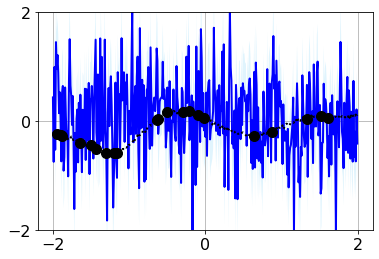

train:  100 0.3834206759929657
train:  200 0.36395731568336487
train:  300 0.2918189764022827
train:  400 0.19504593312740326
train:  500 0.17503711581230164
train:  600 0.22859664261341095
train:  700 0.21403895318508148
train:  800 0.19310396909713745
train:  900 0.17765839397907257
train:  1000 0.15859593451023102


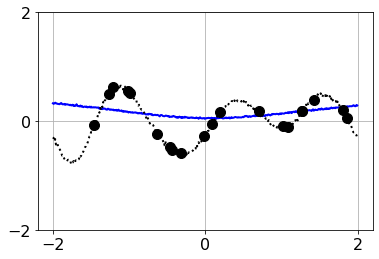

train:  1100 0.18391507863998413
train:  1200 0.2554529309272766
train:  1300 0.2593368589878082
train:  1400 0.1611277461051941
train:  1500 0.2068379521369934
train:  1600 0.21336178481578827
train:  1700 0.23107440769672394
train:  1800 0.2887434959411621
train:  1900 0.43924495577812195
train:  2000 0.14150002598762512


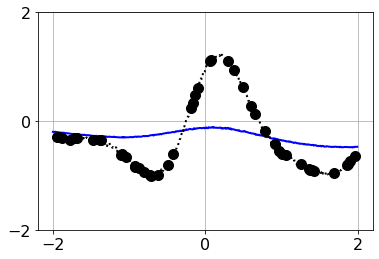

train:  2100 0.25681716203689575
train:  2200 0.18414738774299622
train:  2300 0.18866664171218872
train:  2400 0.21699199080467224
train:  2500 0.16356812417507172
train:  2600 0.12910166382789612
train:  2700 0.15260210633277893
train:  2800 0.4034661650657654
train:  2900 0.23148304224014282
train:  3000 0.23301611840724945


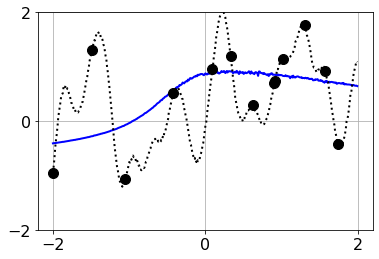

train:  3100 0.256574422121048
train:  3200 0.19759884476661682
train:  3300 0.1684023141860962
train:  3400 0.18308529257774353
train:  3500 0.25621652603149414
train:  3600 0.14580994844436646
train:  3700 0.19153329730033875
train:  3800 0.17958097159862518
train:  3900 0.14232176542282104
train:  4000 0.1475980579853058


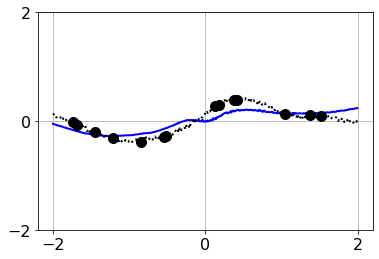

train:  4100 0.13637486100196838
train:  4200 0.2329927682876587
train:  4300 0.11781051009893417
train:  4400 0.15279412269592285
train:  4500 0.13024349510669708
train:  4600 0.1851046085357666
train:  4700 0.22772473096847534
train:  4800 0.18337959051132202
train:  4900 0.20452772080898285
train:  5000 0.09026829153299332


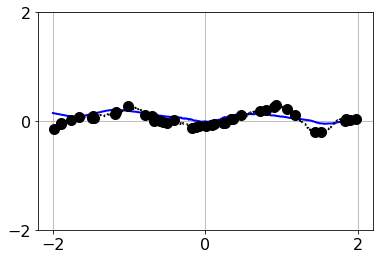

train:  5100 0.17212887108325958
train:  5200 0.08857148140668869
train:  5300 0.0665658637881279
train:  5400 0.16019415855407715
train:  5500 0.11056631058454514
train:  5600 0.09498731046915054
train:  5700 0.11759575456380844
train:  5800 0.16480524837970734
train:  5900 0.09130103141069412
train:  6000 0.11373322457075119


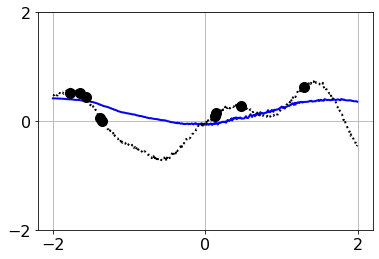

train:  6100 0.22972431778907776
train:  6200 0.1174512431025505
train:  6300 0.159328892827034
train:  6400 0.07121901959180832
train:  6500 0.12331659346818924
train:  6600 0.12725332379341125
train:  6700 0.09220012277364731
train:  6800 0.20644505321979523
train:  6900 0.10386969894170761
train:  7000 0.23383952677249908


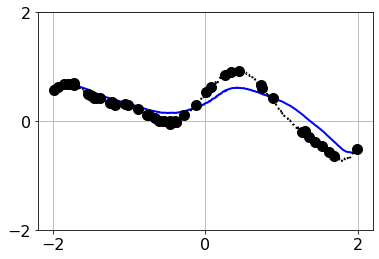

train:  7100 0.13248057663440704
train:  7200 0.08448810130357742
train:  7300 0.09442394226789474
train:  7400 0.17514371871948242
train:  7500 0.09255584329366684
train:  7600 0.2622578740119934
train:  7700 0.17091119289398193
train:  7800 0.06598620116710663
train:  7900 0.0686979666352272
train:  8000 0.06723738461732864


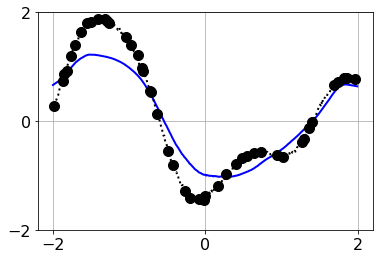

train:  8100 0.16917477548122406
train:  8200 0.09813494235277176
train:  8300 0.23054145276546478
train:  8400 0.10522108525037766
train:  8500 0.10033424943685532
train:  8600 0.06793451309204102
train:  8700 0.2757287621498108
train:  8800 0.08869528025388718
train:  8900 0.11041076481342316
train:  9000 0.09661445766687393


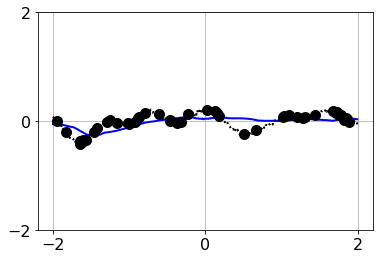

train:  9100 0.11729990690946579
train:  9200 0.11278139054775238
train:  9300 0.1785074770450592
train:  9400 0.08764990419149399
train:  9500 0.09696447849273682
train:  9600 0.11185076832771301
train:  9700 0.15014415979385376
train:  9800 0.12077001482248306
train:  9900 0.19134174287319183
train:  10000 0.07286995649337769


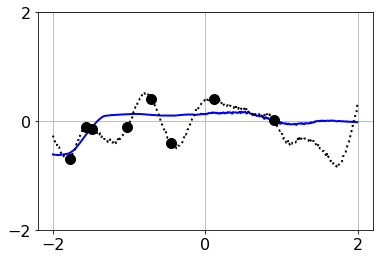

train:  10100 0.10312604159116745
train:  10200 0.2563003897666931
train:  10300 0.21783871948719025
train:  10400 0.11384092271327972
train:  10500 0.06439106166362762
train:  10600 0.21400317549705505
train:  10700 0.09971333295106888
train:  10800 0.12654106318950653
train:  10900 0.12663337588310242
train:  11000 0.06207950413227081


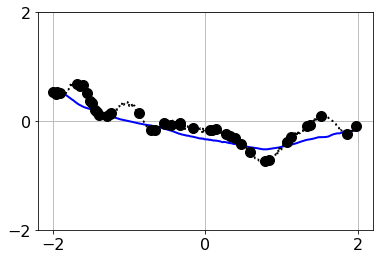

train:  11100 0.13042911887168884
train:  11200 0.10833986103534698
train:  11300 0.18489663302898407
train:  11400 0.18917694687843323
train:  11500 0.28599196672439575
train:  11600 0.06913238763809204
train:  11700 0.09004981815814972
train:  11800 0.19379281997680664
train:  11900 0.22476211190223694
train:  12000 0.06581570953130722


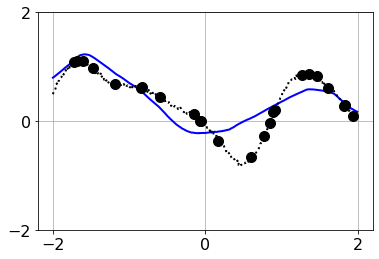

train:  12100 0.07602464407682419
train:  12200 0.10334636270999908
train:  12300 0.15454871952533722
train:  12400 0.22486568987369537
train:  12500 0.1419588327407837
train:  12600 0.07631226629018784
train:  12700 0.09307204186916351
train:  12800 0.13283835351467133
train:  12900 0.20037516951560974
train:  13000 0.08911650627851486


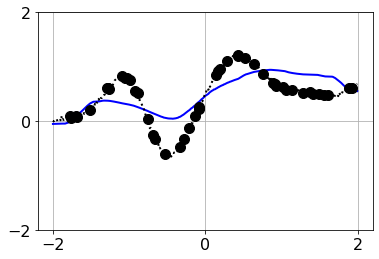

train:  13100 0.09869243949651718
train:  13200 0.14184357225894928
train:  13300 0.1164577379822731
train:  13400 0.061860088258981705
train:  13500 0.1313452422618866
train:  13600 0.08205816149711609
train:  13700 0.13117128610610962
train:  13800 0.13756144046783447
train:  13900 0.08389690518379211
train:  14000 0.0700497180223465


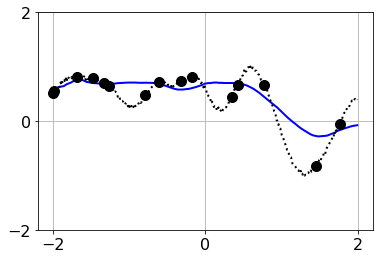

train:  14100 0.06107903644442558
train:  14200 0.19722749292850494
train:  14300 0.13154132664203644
train:  14400 0.28759586811065674
train:  14500 0.2750868797302246
train:  14600 0.0851014256477356
train:  14700 0.06992285698652267
train:  14800 0.061451129615306854
train:  14900 0.26746320724487305
train:  15000 0.1452718824148178


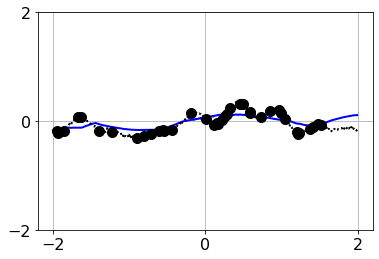

train:  15100 0.09452079236507416
train:  15200 0.1092657819390297
train:  15300 0.08661837130784988
train:  15400 0.0780043676495552
train:  15500 0.12580707669258118
train:  15600 0.07940389961004257
train:  15700 0.05240689590573311
train:  15800 0.087229423224926
train:  15900 0.06951959431171417
train:  16000 0.08439815044403076


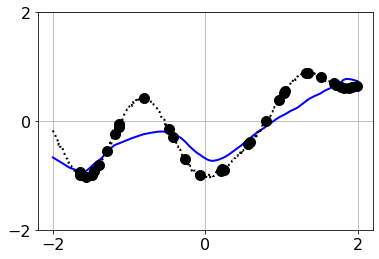

train:  16100 0.07749360799789429
train:  16200 0.06520143151283264
train:  16300 0.272869348526001
train:  16400 0.1747393012046814
train:  16500 0.14251576364040375
train:  16600 0.08073097467422485
train:  16700 0.0680200532078743
train:  16800 0.04500216618180275
train:  16900 0.11260934919118881
train:  17000 0.09670490771532059


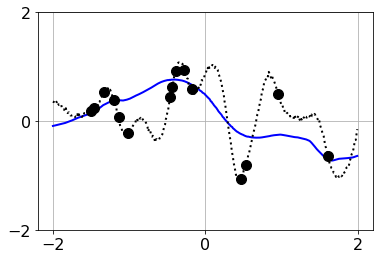

train:  17100 0.13245323300361633
train:  17200 0.0724058449268341
train:  17300 0.1673862338066101
train:  17400 0.10680454969406128
train:  17500 0.09346524626016617
train:  17600 0.100227952003479
train:  17700 0.1546678990125656
train:  17800 0.0715012177824974
train:  17900 0.10952790826559067
train:  18000 0.10217945277690887


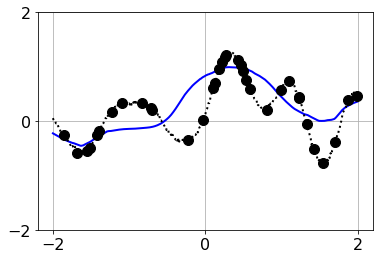

train:  18100 0.09922154247760773
train:  18200 0.06145351752638817
train:  18300 0.11493895202875137
train:  18400 0.06974827498197556
train:  18500 0.11531105637550354
train:  18600 0.10022979229688644
train:  18700 0.14123855531215668
train:  18800 0.22538667917251587
train:  18900 0.18546456098556519
train:  19000 0.11145886033773422


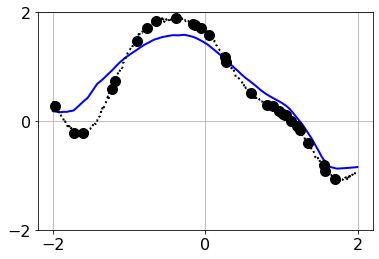

train:  19100 0.06011321395635605
train:  19200 0.09226389229297638
train:  19300 0.1011577844619751
train:  19400 0.06464975327253342
train:  19500 0.1609729528427124
train:  19600 0.11134018748998642
train:  19700 0.13182760775089264
train:  19800 0.1266074776649475
train:  19900 0.03679744526743889
train:  20000 0.05120069906115532


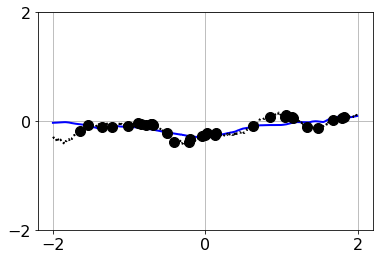

train:  20100 0.09324540942907333
train:  20200 0.13546349108219147
train:  20300 0.04110666736960411
train:  20400 0.15267591178417206
train:  20500 0.07951429486274719
train:  20600 0.17076371610164642
train:  20700 0.1151590347290039
train:  20800 0.085813008248806
train:  20900 0.1459306925535202
train:  21000 0.11676270514726639


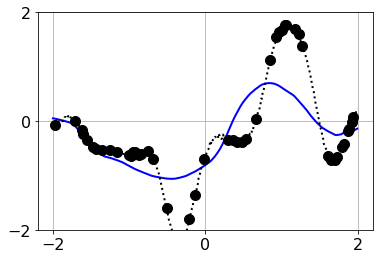

train:  21100 0.18334990739822388
train:  21200 0.12836125493049622
train:  21300 0.14913229644298553
train:  21400 0.2060522884130478
train:  21500 0.06319321691989899
train:  21600 0.058659907430410385
train:  21700 0.07900001853704453
train:  21800 0.13475929200649261
train:  21900 0.06952044367790222
train:  22000 0.09494119882583618


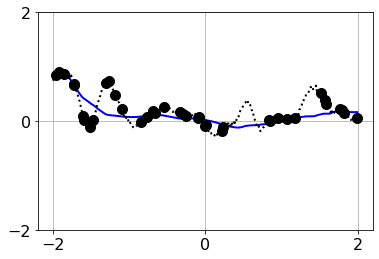

train:  22100 0.07765644043684006
train:  22200 0.07054378092288971
train:  22300 0.06811799108982086
train:  22400 0.050943776965141296
train:  22500 0.12933042645454407
train:  22600 0.1626882553100586
train:  22700 0.05409334599971771
train:  22800 0.09605209529399872
train:  22900 0.06160765513777733
train:  23000 0.06327363103628159


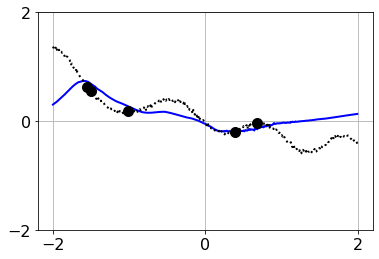

train:  23100 0.0861458033323288
train:  23200 0.12418118119239807
train:  23300 0.15304121375083923
train:  23400 0.20254994928836823
train:  23500 0.3380065858364105
train:  23600 0.07421141862869263
train:  23700 0.15655669569969177
train:  23800 0.0812365785241127
train:  23900 0.08977063745260239
train:  24000 0.11761713027954102


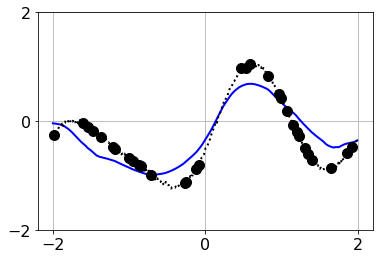

train:  24100 0.1722276657819748
train:  24200 0.08145324885845184
train:  24300 0.13707970082759857
train:  24400 0.11005760729312897
train:  24500 0.12267398834228516
train:  24600 0.09891709685325623
train:  24700 0.042328741401433945
train:  24800 0.06233714893460274
train:  24900 0.027648745104670525
train:  25000 0.06502166390419006


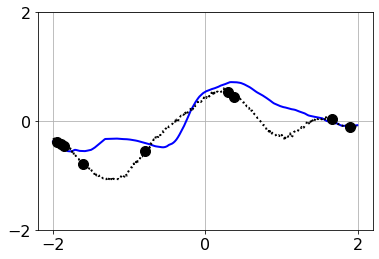

train:  25100 0.06790035218000412
train:  25200 0.04715210199356079
train:  25300 0.15496836602687836
train:  25400 0.0643690899014473
train:  25500 0.11463838070631027
train:  25600 0.1142677366733551
train:  25700 0.17304106056690216
train:  25800 0.14278197288513184
train:  25900 0.14792799949645996
train:  26000 0.08475960046052933


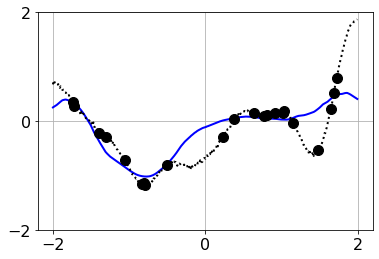

train:  26100 0.04013639688491821
train:  26200 0.16215719282627106
train:  26300 0.0678756982088089
train:  26400 0.07784729450941086
train:  26500 0.14186416566371918
train:  26600 0.07934733480215073
train:  26700 0.0881149023771286
train:  26800 0.042749252170324326
train:  26900 0.1139574721455574
train:  27000 0.08402381092309952


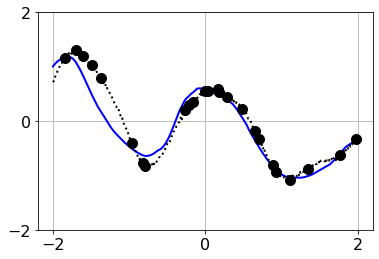

train:  27100 0.08216968923807144
train:  27200 0.06931717693805695
train:  27300 0.06032540276646614
train:  27400 0.17256340384483337
train:  27500 0.1413189023733139
train:  27600 0.17857354879379272
train:  27700 0.048301588743925095
train:  27800 0.08356717228889465
train:  27900 0.16906005144119263
train:  28000 0.09480513632297516


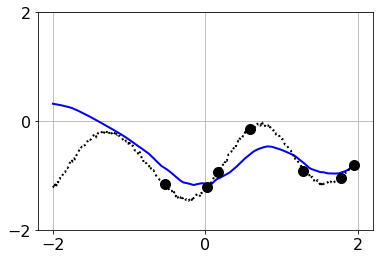

train:  28100 0.09917265176773071
train:  28200 0.2078675776720047
train:  28300 0.09830179810523987
train:  28400 0.08734826743602753
train:  28500 0.07698643207550049
train:  28600 0.15847590565681458
train:  28700 0.07233860343694687
train:  28800 0.18715262413024902
train:  28900 0.1364402174949646
train:  29000 0.09759826213121414


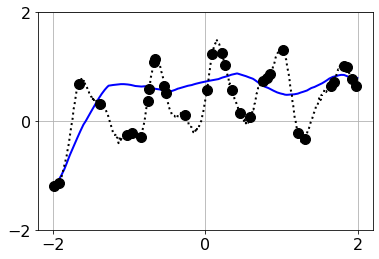

train:  29100 0.0653371661901474
train:  29200 0.0299490038305521
train:  29300 0.06036105006933212
train:  29400 0.04657759517431259
train:  29500 0.0617159940302372
train:  29600 0.11320419609546661
train:  29700 0.0907471552491188
train:  29800 0.04697691276669502
train:  29900 0.12940676510334015
train:  30000 0.07752475887537003


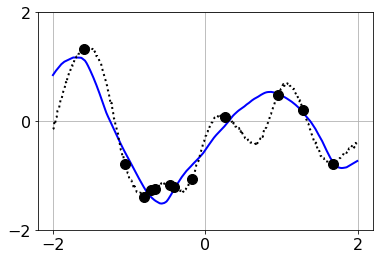

train:  30100 0.2400924563407898
train:  30200 0.11125493794679642
train:  30300 0.081951804459095
train:  30400 0.0522930845618248
train:  30500 0.10574167221784592
train:  30600 0.07889575511217117
train:  30700 0.10093774646520615
train:  30800 0.035872481763362885
train:  30900 0.05894244462251663
train:  31000 0.09360294044017792


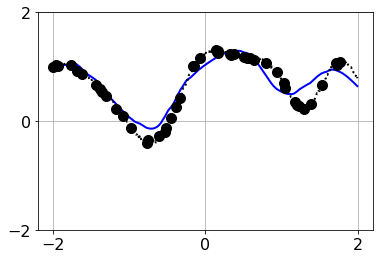

train:  31100 0.10059687495231628
train:  31200 0.08420410752296448
train:  31300 0.22161759436130524
train:  31400 0.056485410779714584
train:  31500 0.0677230954170227
train:  31600 0.08899065852165222
train:  31700 0.06137840077280998
train:  31800 0.05929603427648544
train:  31900 0.10865940898656845
train:  32000 0.10226912051439285


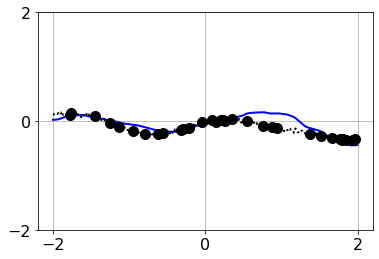

train:  32100 0.05265442281961441
train:  32200 0.05437334254384041
train:  32300 0.05980140343308449
train:  32400 0.07875852286815643
train:  32500 0.04971206933259964
train:  32600 0.16456782817840576
train:  32700 0.08775117993354797
train:  32800 0.12383634597063065
train:  32900 0.040135663002729416
train:  33000 0.09617719054222107


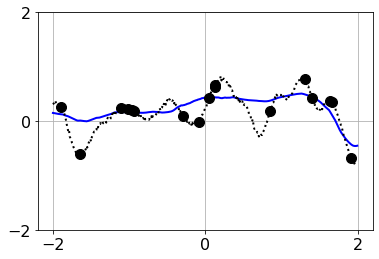

train:  33100 0.09648478031158447
train:  33200 0.06786299496889114
train:  33300 0.1469203680753708
train:  33400 0.09588717669248581
train:  33500 0.1356690227985382
train:  33600 0.05677800253033638
train:  33700 0.03156173974275589
train:  33800 0.05348438769578934
train:  33900 0.05665137246251106
train:  34000 0.021296631544828415


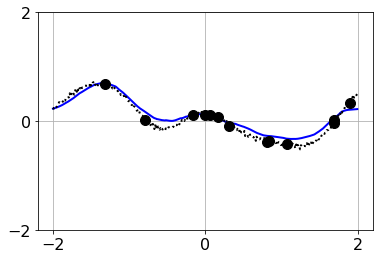

train:  34100 0.10900368541479111
train:  34200 0.05651044473052025
train:  34300 0.042747899889945984
train:  34400 0.07738222181797028
train:  34500 0.05871061980724335
train:  34600 0.05418781191110611
train:  34700 0.04002145677804947
train:  34800 0.19202005863189697
train:  34900 0.05903489515185356
train:  35000 0.20143906772136688


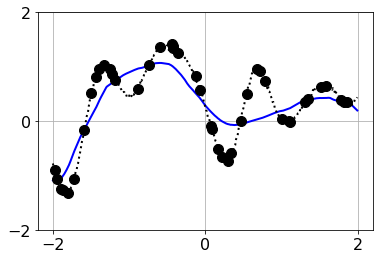

train:  35100 0.08506228029727936
train:  35200 0.08469744026660919
train:  35300 0.05009305849671364
train:  35400 0.13228155672550201
train:  35500 0.11092682182788849
train:  35600 0.0716513991355896
train:  35700 0.1816030889749527
train:  35800 0.13577917218208313
train:  35900 0.08113958686590195
train:  36000 0.33580267429351807


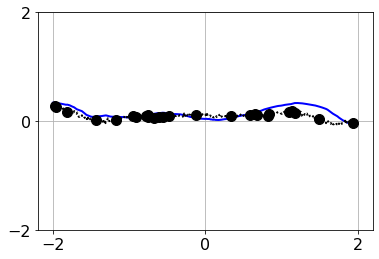

train:  36100 0.04659808427095413
train:  36200 0.18752135336399078
train:  36300 0.07717008143663406
train:  36400 0.09447512775659561
train:  36500 0.059551771730184555
train:  36600 0.04271184280514717
train:  36700 0.11848471313714981
train:  36800 0.05605592578649521
train:  36900 0.07818092405796051
train:  37000 0.18028134107589722


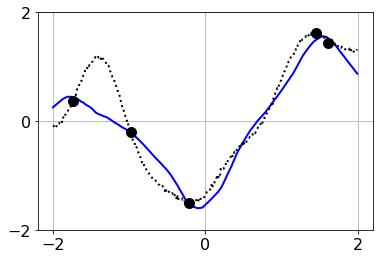

train:  37100 0.03203483298420906
train:  37200 0.07076665014028549
train:  37300 0.13777291774749756
train:  37400 0.10591110587120056
train:  37500 0.04066291078925133
train:  37600 0.11569123715162277
train:  37700 0.10406497120857239
train:  37800 0.05207762494683266
train:  37900 0.07300636172294617
train:  38000 0.10167378932237625


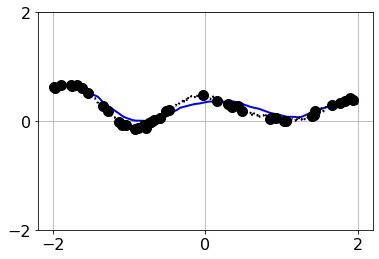

train:  38100 0.07791215926408768
train:  38200 0.15094541013240814
train:  38300 0.16748502850532532
train:  38400 0.08433813601732254
train:  38500 0.10660897940397263
train:  38600 0.055053915828466415
train:  38700 0.14590005576610565
train:  38800 0.09196361899375916
train:  38900 0.08918824046850204
train:  39000 0.04844233766198158


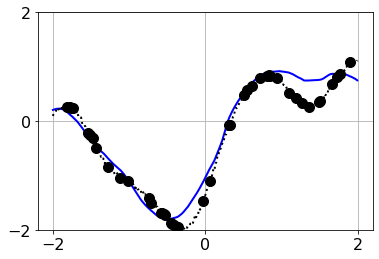

train:  39100 0.06891804933547974
train:  39200 0.06548216938972473
train:  39300 0.05112389475107193
train:  39400 0.07373321056365967
train:  39500 0.04271942749619484
train:  39600 0.16935960948467255
train:  39700 0.04334127902984619
train:  39800 0.0964677631855011
train:  39900 0.07279103249311447
train:  40000 0.15457063913345337


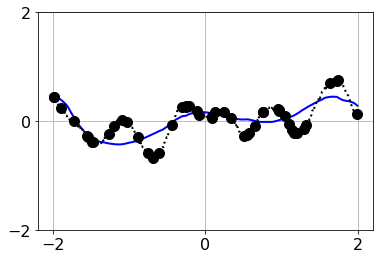

train:  40100 0.05839848145842552
train:  40200 0.10395850986242294
train:  40300 0.05711160600185394
train:  40400 0.04600279778242111
train:  40500 0.08261243253946304
train:  40600 0.06911037862300873
train:  40700 0.06279896944761276
train:  40800 0.09158491343259811
train:  40900 0.06725906580686569
train:  41000 0.07426628470420837


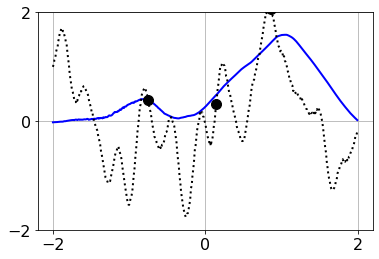

train:  41100 0.0635232925415039
train:  41200 0.059637535363435745
train:  41300 0.04026111587882042
train:  41400 0.04423698037862778
train:  41500 0.09395188093185425
train:  41600 0.05751805379986763
train:  41700 0.04956270381808281
train:  41800 0.0925455167889595
train:  41900 0.07659374922513962
train:  42000 0.10514899343252182


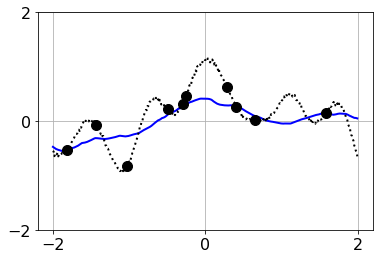

train:  42100 0.04665316641330719
train:  42200 0.03580673784017563
train:  42300 0.06039845943450928
train:  42400 0.07882346212863922
train:  42500 0.03824615105986595
train:  42600 0.16233444213867188
train:  42700 0.09528855979442596
train:  42800 0.08634644001722336
train:  42900 0.08521123230457306
train:  43000 0.083195261657238


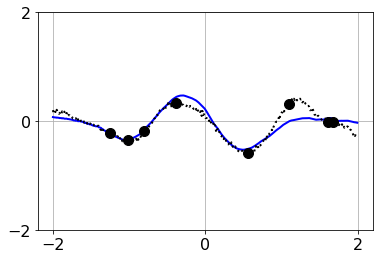

train:  43100 0.0672881230711937
train:  43200 0.04546424373984337
train:  43300 0.21907712519168854
train:  43400 0.0612364336848259
train:  43500 0.07751353830099106
train:  43600 0.09519899636507034
train:  43700 0.060936227440834045
train:  43800 0.14506393671035767
train:  43900 0.2594975531101227
train:  44000 0.0683986097574234


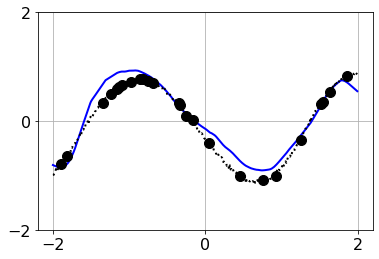

train:  44100 0.06905518472194672
train:  44200 0.07635820657014847
train:  44300 0.053726281970739365
train:  44400 0.1016705259680748
train:  44500 0.061644259840250015
train:  44600 0.17640163004398346
train:  44700 0.04375206306576729
train:  44800 0.07647296041250229
train:  44900 0.08479450643062592
train:  45000 0.030127258971333504


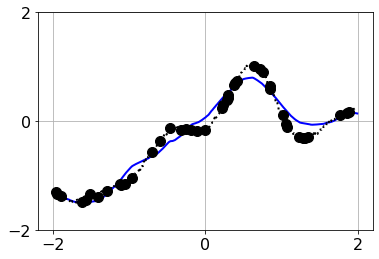

train:  45100 0.06858077645301819
train:  45200 0.06859264522790909
train:  45300 0.05689280107617378
train:  45400 0.08970653265714645
train:  45500 0.2749009132385254
train:  45600 0.05348695069551468
train:  45700 0.072376549243927
train:  45800 0.031231217086315155
train:  45900 0.05901499092578888
train:  46000 0.17455501854419708


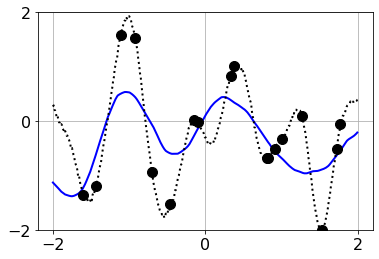

train:  46100 0.0730518102645874
train:  46200 0.1058412566781044
train:  46300 0.07473106682300568
train:  46400 0.05696823447942734
train:  46500 0.10670720040798187
train:  46600 0.04859687760472298
train:  46700 0.06281904876232147
train:  46800 0.08837277442216873
train:  46900 0.04959866404533386
train:  47000 0.08153834939002991


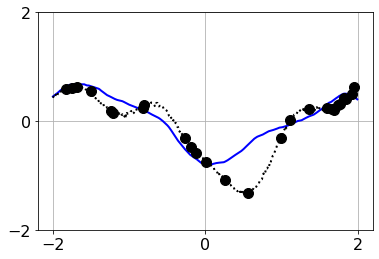

train:  47100 0.057898927479982376
train:  47200 0.3759990632534027
train:  47300 0.11038617789745331
train:  47400 0.048192478716373444
train:  47500 0.17438377439975739
train:  47600 0.09625238180160522
train:  47700 0.18074150383472443
train:  47800 0.05976219102740288
train:  47900 0.05708800628781319
train:  48000 0.04570223018527031


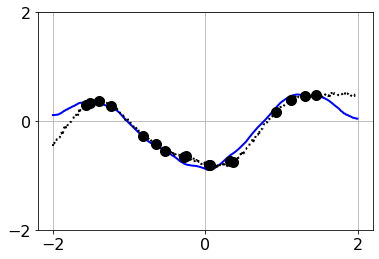

train:  48100 0.0968390554189682
train:  48200 0.10533158481121063
train:  48300 0.024512287229299545
train:  48400 0.1977875679731369
train:  48500 0.14819009602069855
train:  48600 0.1889278143644333
train:  48700 0.03356950730085373
train:  48800 0.055195439606904984
train:  48900 0.05562727525830269
train:  49000 0.07113821059465408


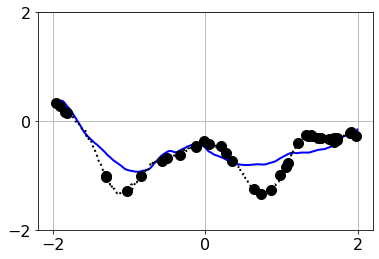

train:  49100 0.0791395753622055
train:  49200 0.07330325245857239
train:  49300 0.07376804202795029
train:  49400 0.11249023675918579
train:  49500 0.06175211817026138
train:  49600 0.19527865946292877
train:  49700 0.09064523130655289
train:  49800 0.12068333476781845
train:  49900 0.07028627395629883
train:  50000 0.08035778254270554


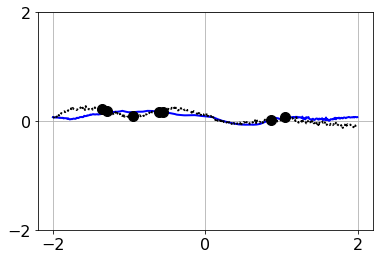

train:  50100 0.03496837615966797
train:  50200 0.07442199438810349
train:  50300 0.04483181610703468
train:  50400 0.062456484884023666
train:  50500 0.04653310775756836
train:  50600 0.023358995094895363
train:  50700 0.169806107878685
train:  50800 0.06822429597377777
train:  50900 0.06268735975027084
train:  51000 0.0439356192946434


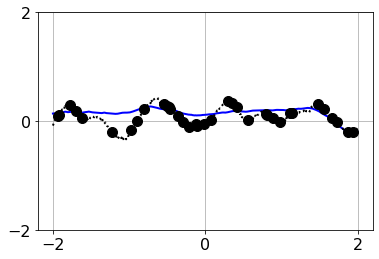

train:  51100 0.061411987990140915
train:  51200 0.06917428970336914
train:  51300 0.1426800638437271
train:  51400 0.04360022023320198
train:  51500 0.056111231446266174
train:  51600 0.05542651563882828
train:  51700 0.10071618854999542
train:  51800 0.09168858826160431
train:  51900 0.07439567148685455
train:  52000 0.055064305663108826


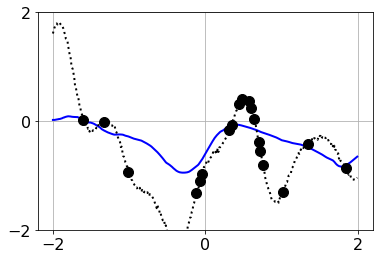

train:  52100 0.08470852673053741
train:  52200 0.028626510873436928
train:  52300 0.07500416785478592
train:  52400 0.16648666560649872
train:  52500 0.047265127301216125
train:  52600 0.0919179916381836
train:  52700 0.07189909368753433
train:  52800 0.08150177448987961
train:  52900 0.10383247584104538
train:  53000 0.07434917986392975


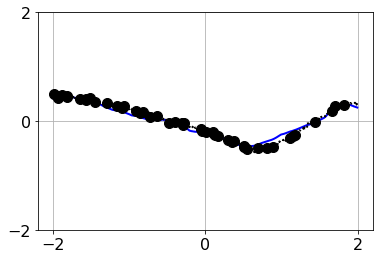

train:  53100 0.07373092323541641
train:  53200 0.07821691781282425
train:  53300 0.05292244628071785
train:  53400 0.08593309670686722
train:  53500 0.36820754408836365
train:  53600 0.12766319513320923
train:  53700 0.19579102098941803
train:  53800 0.10214100778102875
train:  53900 0.142894446849823
train:  54000 0.051228493452072144


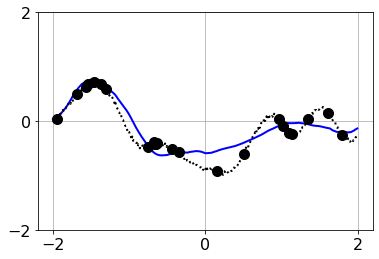

train:  54100 0.18150100111961365
train:  54200 0.044436946511268616
train:  54300 0.06557727605104446
train:  54400 0.052906181663274765
train:  54500 0.1340663880109787
train:  54600 0.04015391319990158
train:  54700 0.06124962866306305
train:  54800 0.05033595860004425
train:  54900 0.037899263203144073
train:  55000 0.02988058142364025


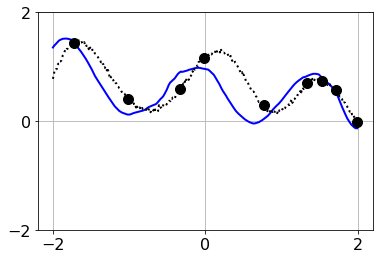

train:  55100 0.11526260524988174
train:  55200 0.10456234216690063
train:  55300 0.043730393052101135
train:  55400 0.06624005734920502
train:  55500 0.15038159489631653
train:  55600 0.03115004673600197
train:  55700 0.0506439283490181
train:  55800 0.051236867904663086
train:  55900 0.052849508821964264
train:  56000 0.07670678943395615


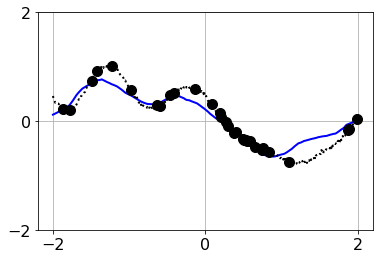

train:  56100 0.12478706240653992
train:  56200 0.052348311990499496
train:  56300 0.05422079935669899
train:  56400 0.03865388408303261
train:  56500 0.05212961509823799
train:  56600 0.08739599585533142
train:  56700 0.08759555965662003
train:  56800 0.10029526799917221
train:  56900 0.026326477527618408
train:  57000 0.0645449161529541


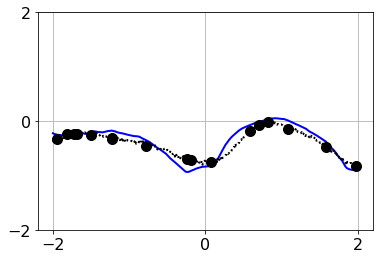

train:  57100 0.16611391305923462
train:  57200 0.054404981434345245
train:  57300 0.10686752945184708
train:  57400 0.058445513248443604
train:  57500 0.06846451014280319
train:  57600 0.03889121860265732
train:  57700 0.1281081736087799
train:  57800 0.05098588764667511
train:  57900 0.020319996401667595
train:  58000 0.053227055817842484


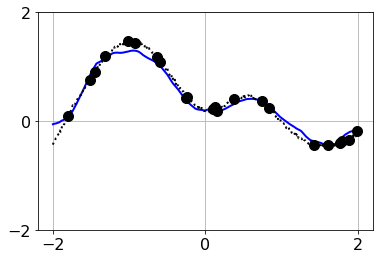

train:  58100 0.08907446265220642
train:  58200 0.022821201011538506
train:  58300 0.04211672022938728
train:  58400 0.045927759259939194
train:  58500 0.035833802074193954
train:  58600 0.03160276263952255
train:  58700 0.02659565769135952
train:  58800 0.06136656925082207
train:  58900 0.03610920161008835
train:  59000 0.14181187748908997


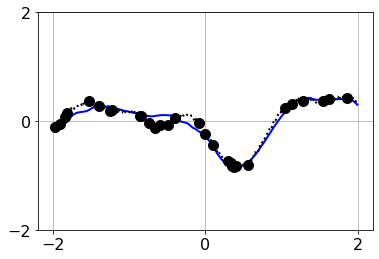

train:  59100 0.04680618643760681
train:  59200 0.04154491424560547
train:  59300 0.05696851760149002
train:  59400 0.06452056765556335
train:  59500 0.07483197748661041
train:  59600 0.1782136708498001
train:  59700 0.02658119425177574
train:  59800 0.023127861320972443
train:  59900 0.05910729989409447
train:  60000 0.06784199178218842


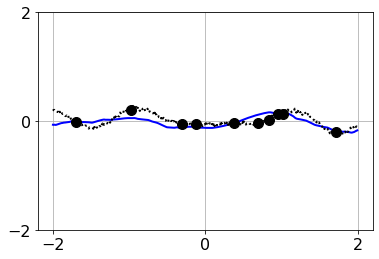

train:  60100 0.054399728775024414
train:  60200 0.12003679573535919
train:  60300 0.06436068564653397
train:  60400 0.04404505342245102
train:  60500 0.07198263704776764
train:  60600 0.029483884572982788
train:  60700 0.08360934257507324
train:  60800 0.1391705572605133
train:  60900 0.29746508598327637
train:  61000 0.05516624450683594


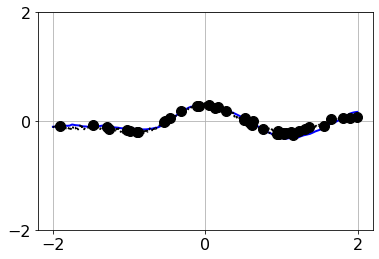

train:  61100 0.1780211329460144
train:  61200 0.03655359521508217
train:  61300 0.10451780259609222
train:  61400 0.03522183373570442
train:  61500 0.11544730514287949
train:  61600 0.077774778008461
train:  61700 0.0530225969851017
train:  61800 0.027554303407669067
train:  61900 0.1340397745370865
train:  62000 0.04358632117509842


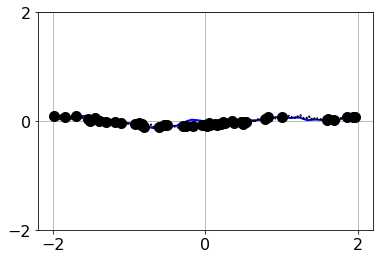

train:  62100 0.0787116065621376
train:  62200 0.07558155804872513
train:  62300 0.040828313678503036
train:  62400 0.14806325733661652
train:  62500 0.04099695011973381
train:  62600 0.1094229593873024
train:  62700 0.023024894297122955
train:  62800 0.05038600042462349
train:  62900 0.02414095029234886
train:  63000 0.11117921024560928


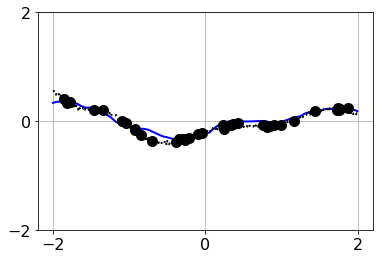

train:  63100 0.027047049254179
train:  63200 0.019843239337205887
train:  63300 0.07617233693599701
train:  63400 0.04849424958229065
train:  63500 0.05773463845252991
train:  63600 0.047620367258787155
train:  63700 0.029195504263043404
train:  63800 0.05770338326692581
train:  63900 0.22669748961925507
train:  64000 0.0780913233757019


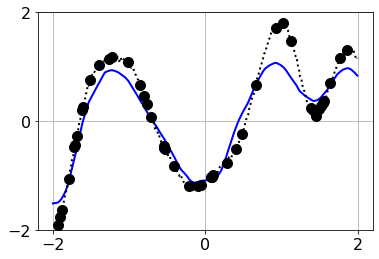

train:  64100 0.060455821454524994
train:  64200 0.05295467749238014
train:  64300 0.10881257057189941
train:  64400 0.08376700431108475
train:  64500 0.1052154079079628
train:  64600 0.12880246341228485
train:  64700 0.03758067265152931
train:  64800 0.08363667875528336
train:  64900 0.06070812791585922
train:  65000 0.03962239623069763


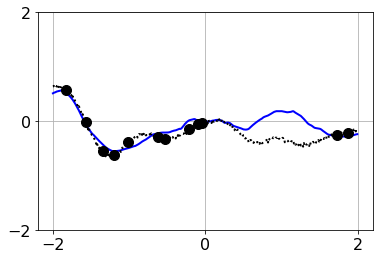

train:  65100 0.2132783830165863
train:  65200 0.036976926028728485
train:  65300 0.08058670908212662
train:  65400 0.06260170042514801
train:  65500 0.10319693386554718
train:  65600 0.06636727601289749
train:  65700 0.07666986435651779
train:  65800 0.08394728600978851
train:  65900 0.0520772822201252
train:  66000 0.024443654343485832


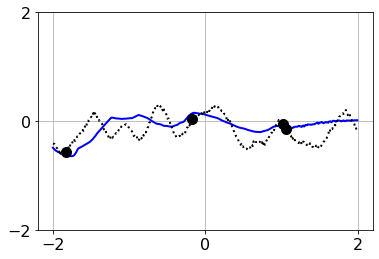

train:  66100 0.036016836762428284
train:  66200 0.1229144036769867
train:  66300 0.046336106956005096
train:  66400 0.09163989871740341
train:  66500 0.039315029978752136
train:  66600 0.03571316972374916
train:  66700 0.10087238997220993
train:  66800 0.08164895325899124
train:  66900 0.029624881222844124
train:  67000 0.13653767108917236


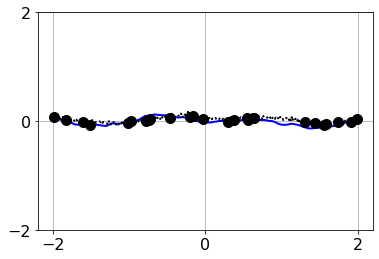

train:  67100 0.0189592856913805
train:  67200 0.04293259233236313
train:  67300 0.04534037411212921
train:  67400 0.08146671950817108
train:  67500 0.03125705197453499
train:  67600 0.03386928513646126
train:  67700 0.04297243058681488
train:  67800 0.059214867651462555
train:  67900 0.09428473562002182
train:  68000 0.02492397278547287


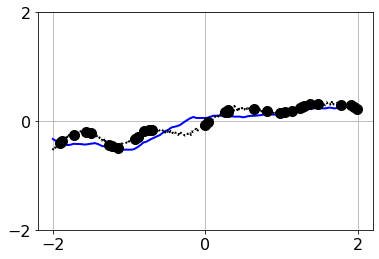

train:  68100 0.054262008517980576
train:  68200 0.02028295211493969
train:  68300 0.11540882289409637
train:  68400 0.04155479371547699
train:  68500 0.02110825479030609
train:  68600 0.08178403228521347
train:  68700 0.06283190846443176
train:  68800 0.11267086863517761
train:  68900 0.09414555877447128
train:  69000 0.06511329114437103


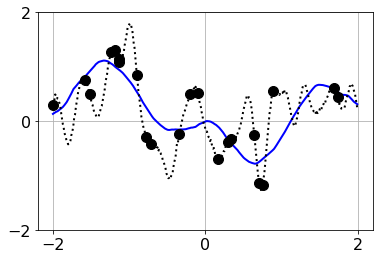

train:  69100 0.1326085329055786
train:  69200 0.08173523843288422
train:  69300 0.07233792543411255
train:  69400 0.11513505131006241
train:  69500 0.08912867307662964
train:  69600 0.0662609338760376
train:  69700 0.05592833459377289
train:  69800 0.05125511437654495
train:  69900 0.054479412734508514
train:  70000 0.1905198097229004


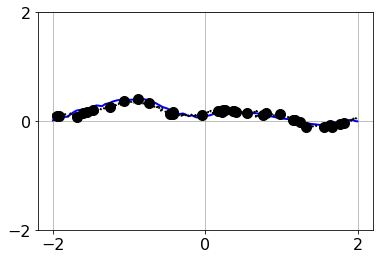

train:  70100 0.05987429618835449
train:  70200 0.05306829884648323
train:  70300 0.0648726299405098
train:  70400 0.035637546330690384
train:  70500 0.05842870473861694
train:  70600 0.0551341213285923
train:  70700 0.04929308593273163
train:  70800 0.19262583553791046
train:  70900 0.07985672354698181
train:  71000 0.03280412778258324


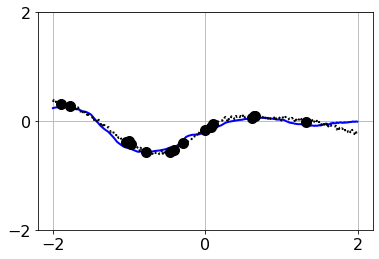

train:  71100 0.08162373304367065
train:  71200 0.030595386400818825
train:  71300 0.04796455800533295
train:  71400 0.10793103277683258
train:  71500 0.024738216772675514
train:  71600 0.028462199494242668
train:  71700 0.0408971793949604
train:  71800 0.0628185048699379
train:  71900 0.1248386800289154
train:  72000 0.0708528608083725


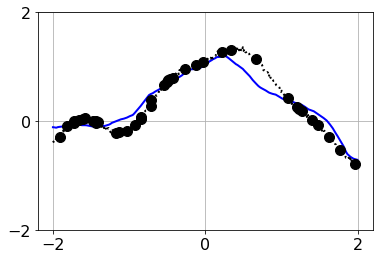

train:  72100 0.05394424870610237
train:  72200 0.050667181611061096
train:  72300 0.0626169741153717
train:  72400 0.06900909543037415
train:  72500 0.012934376485645771
train:  72600 0.017749028280377388
train:  72700 0.06074795499444008
train:  72800 0.043880488723516464
train:  72900 0.30312949419021606
train:  73000 0.01703544333577156


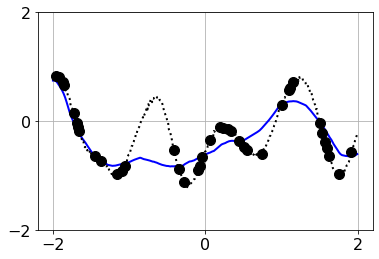

train:  73100 0.04659105837345123
train:  73200 0.054100245237350464
train:  73300 0.02301911450922489
train:  73400 0.128724604845047
train:  73500 0.08081120997667313
train:  73600 0.044556569308042526
train:  73700 0.0346185676753521
train:  73800 0.04396986961364746
train:  73900 0.090719074010849
train:  74000 0.11492852121591568


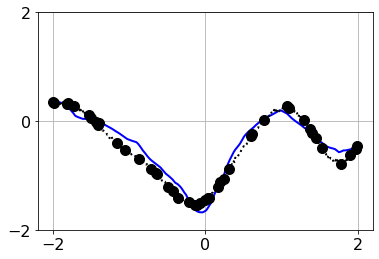

train:  74100 0.03974219039082527
train:  74200 0.21327053010463715
train:  74300 0.032266952097415924
train:  74400 0.031030550599098206
train:  74500 0.11715646833181381
train:  74600 0.05304114148020744
train:  74700 0.030865784734487534
train:  74800 0.06519702076911926
train:  74900 0.07354801148176193
train:  75000 0.07010437548160553


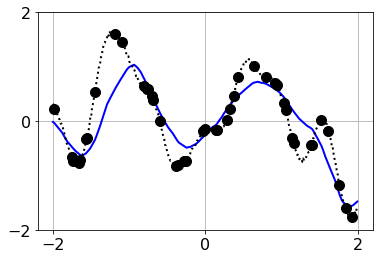

train:  75100 0.06061908230185509
train:  75200 0.18677781522274017
train:  75300 0.11175010353326797
train:  75400 0.036998238414525986
train:  75500 0.08770029246807098
train:  75600 0.04034486785531044
train:  75700 0.035089459270238876
train:  75800 0.03284735977649689
train:  75900 0.03150099888443947
train:  76000 0.06678199768066406


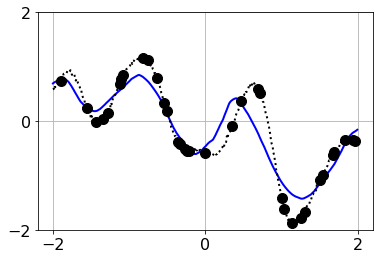

train:  76100 0.05201676860451698
train:  76200 0.08995335549116135
train:  76300 0.04709227383136749
train:  76400 0.07206070423126221
train:  76500 0.03870873153209686
train:  76600 0.062223657965660095
train:  76700 0.04806404188275337
train:  76800 0.34726962447166443
train:  76900 0.051612671464681625
train:  77000 0.040002305060625076


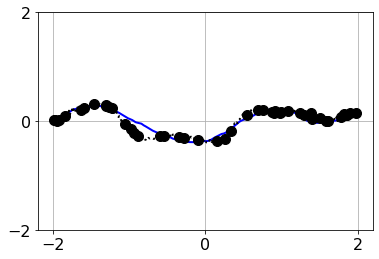

train:  77100 0.021083153784275055
train:  77200 0.054697148501873016
train:  77300 0.04962186887860298
train:  77400 0.02707664854824543
train:  77500 0.043741241097450256
train:  77600 0.0468447282910347
train:  77700 0.06927734613418579
train:  77800 0.04626083746552467
train:  77900 0.06515859067440033
train:  78000 0.027794644236564636


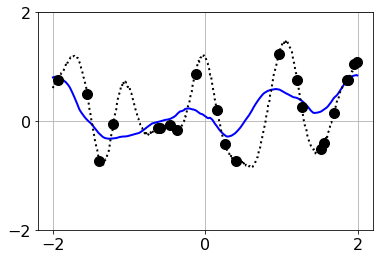

train:  78100 0.021693196147680283
train:  78200 0.05860210582613945
train:  78300 0.038964562118053436
train:  78400 0.1119716539978981
train:  78500 0.06775660812854767
train:  78600 0.03377508744597435
train:  78700 0.02884128876030445
train:  78800 0.3033235967159271
train:  78900 0.03410816565155983
train:  79000 0.1669146865606308


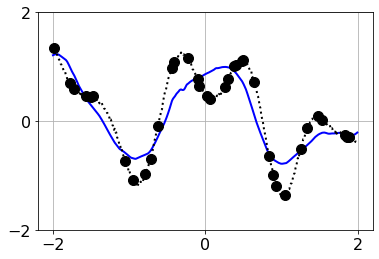

train:  79100 0.23169396817684174
train:  79200 0.042727719992399216
train:  79300 0.23865042626857758
train:  79400 0.052418794482946396
train:  79500 0.15342609584331512
train:  79600 0.05573015660047531
train:  79700 0.10262689739465714
train:  79800 0.1277351826429367
train:  79900 0.012189768254756927
train:  80000 0.06435562670230865


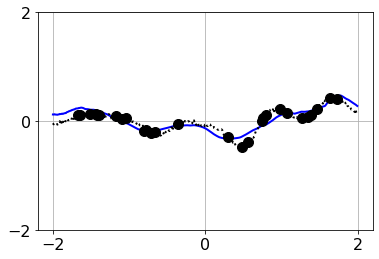

train:  80100 0.06259281188249588
train:  80200 0.09548456966876984
train:  80300 0.044327378273010254
train:  80400 0.031813640147447586
train:  80500 0.031001167371869087
train:  80600 0.2253805249929428
train:  80700 0.06695802509784698
train:  80800 0.11262606084346771
train:  80900 0.040534306317567825
train:  81000 0.04205941781401634


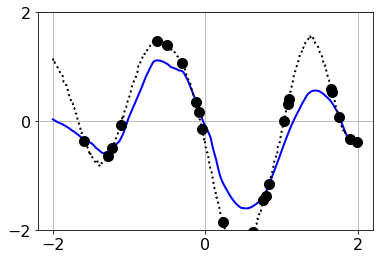

train:  81100 0.03007722645998001
train:  81200 0.033381737768650055
train:  81300 0.05734584853053093
train:  81400 0.04562533646821976
train:  81500 0.07718014717102051
train:  81600 0.030428173020482063
train:  81700 0.06918425858020782
train:  81800 0.020459206774830818
train:  81900 0.02913239784538746
train:  82000 0.038819584995508194


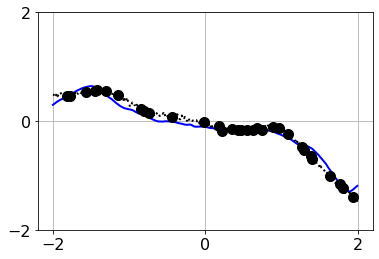

train:  82100 0.3352489471435547
train:  82200 0.06577789038419724
train:  82300 0.03137680143117905
train:  82400 0.055421825498342514
train:  82500 0.020132575184106827
train:  82600 0.03136921674013138
train:  82700 0.03278511017560959
train:  82800 0.16327734291553497
train:  82900 0.08369040489196777
train:  83000 0.03024441748857498


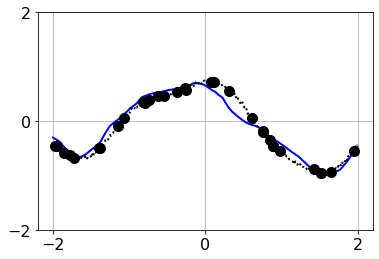

train:  83100 0.03174460306763649
train:  83200 0.06714199483394623
train:  83300 0.04004322737455368
train:  83400 0.07028775662183762
train:  83500 0.03517505154013634
train:  83600 0.09905756264925003
train:  83700 0.023169275373220444
train:  83800 0.06509476155042648
train:  83900 0.0507640466094017
train:  84000 0.041692595928907394


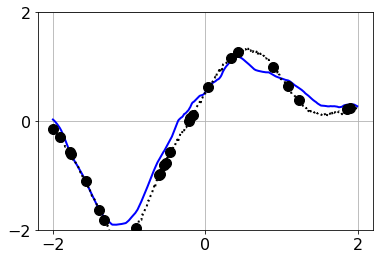

train:  84100 0.11981956660747528
train:  84200 0.04977291077375412
train:  84300 0.06515873223543167
train:  84400 0.0815005674958229
train:  84500 0.06666968762874603
train:  84600 0.04542205110192299
train:  84700 0.03290603682398796
train:  84800 0.04897654429078102
train:  84900 0.04095844924449921
train:  85000 0.04507318139076233


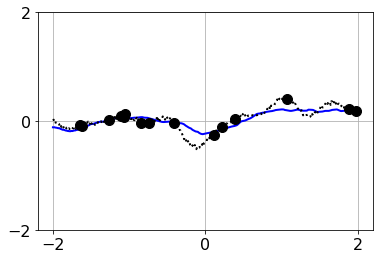

train:  85100 0.044979341328144073
train:  85200 0.04311049357056618
train:  85300 0.1411491483449936
train:  85400 0.051728274673223495
train:  85500 0.0847698524594307
train:  85600 0.04394879937171936
train:  85700 0.04395456612110138
train:  85800 0.10204329341650009
train:  85900 0.032773446291685104
train:  86000 0.031240183860063553


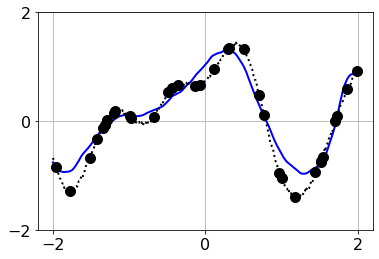

train:  86100 0.04739180579781532
train:  86200 0.12713667750358582
train:  86300 0.07327216118574142
train:  86400 0.1385412961244583
train:  86500 0.020282793790102005
train:  86600 0.1502029001712799
train:  86700 0.04837396368384361
train:  86800 0.3604436218738556
train:  86900 0.09086821228265762
train:  87000 0.04277879372239113


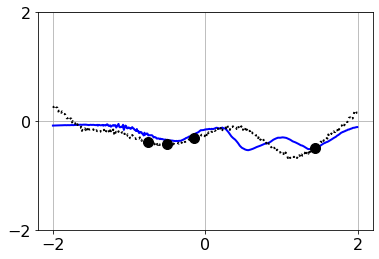

train:  87100 0.043284203857183456
train:  87200 0.07496301829814911
train:  87300 0.09838363528251648
train:  87400 0.16560734808444977
train:  87500 0.15258845686912537
train:  87600 0.03499007225036621
train:  87700 0.06551091372966766
train:  87800 0.05693899467587471
train:  87900 0.05982660874724388
train:  88000 0.17539280652999878


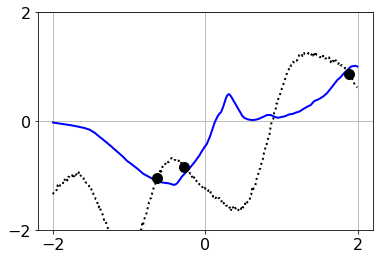

train:  88100 0.06564649194478989
train:  88200 0.04037558659911156
train:  88300 0.03474040701985359
train:  88400 0.046668920665979385
train:  88500 0.05679616332054138
train:  88600 0.049745552241802216
train:  88700 0.10579931735992432
train:  88800 0.02148609608411789
train:  88900 0.06586667150259018
train:  89000 0.052149876952171326


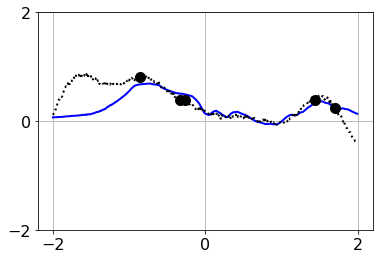

train:  89100 0.016850793734192848
train:  89200 0.02639768086373806
train:  89300 0.22778643667697906
train:  89400 0.05086477845907211
train:  89500 0.08776737004518509
train:  89600 0.01644561067223549
train:  89700 0.034534819424152374
train:  89800 0.06003712862730026
train:  89900 0.031226523220539093
train:  90000 0.2960847318172455


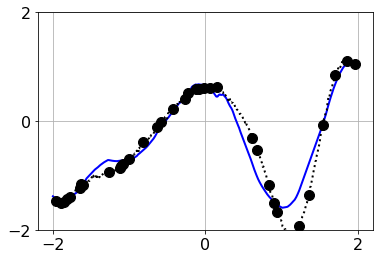

train:  90100 0.06228502467274666
train:  90200 0.03209943696856499
train:  90300 0.16741251945495605
train:  90400 0.023711031302809715
train:  90500 0.044777121394872665
train:  90600 0.04725544899702072
train:  90700 0.27367815375328064
train:  90800 0.20158572494983673
train:  90900 0.02458660490810871
train:  91000 0.15630260109901428


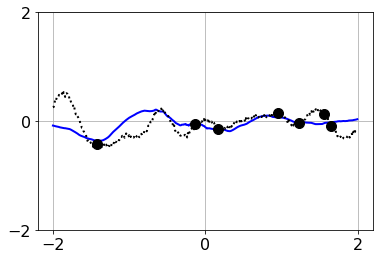

train:  91100 0.07752333581447601
train:  91200 0.0638267770409584
train:  91300 0.03608304262161255
train:  91400 0.044559046626091
train:  91500 0.06615564227104187
train:  91600 0.04146276041865349
train:  91700 0.2793448865413666
train:  91800 0.037506356835365295
train:  91900 0.15209943056106567
train:  92000 0.07867038995027542


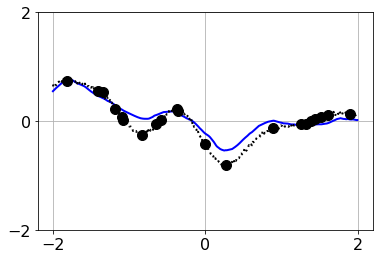

train:  92100 0.16967138648033142
train:  92200 0.06293980032205582
train:  92300 0.053985148668289185
train:  92400 0.04903346300125122
train:  92500 0.030929919332265854
train:  92600 0.15337811410427094
train:  92700 0.06582321226596832
train:  92800 0.01889071613550186
train:  92900 0.12052255123853683
train:  93000 0.07476240396499634


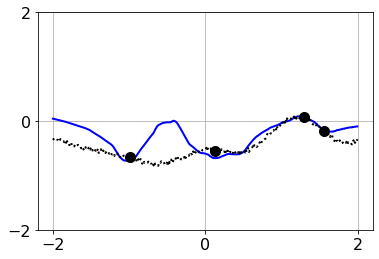

train:  93100 0.04029242694377899
train:  93200 0.24323770403862
train:  93300 0.03565322607755661
train:  93400 0.05532355234026909
train:  93500 0.06763219088315964
train:  93600 0.1046219989657402
train:  93700 0.0267888642847538
train:  93800 0.12706239521503448
train:  93900 0.020901957526803017
train:  94000 0.08584626019001007


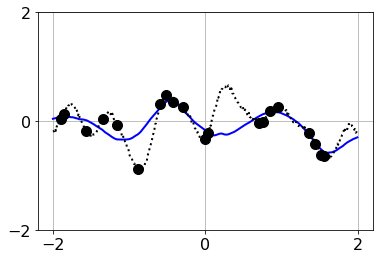

train:  94100 0.04044380411505699
train:  94200 0.09504660218954086
train:  94300 0.05738448724150658
train:  94400 0.06028246879577637
train:  94500 0.031098047271370888
train:  94600 0.052696771919727325
train:  94700 0.08025042712688446
train:  94800 0.05908896401524544
train:  94900 0.012895364314317703
train:  95000 0.03651948273181915


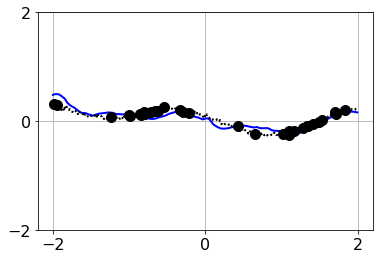

train:  95100 0.052929289638996124
train:  95200 0.04370599612593651
train:  95300 0.027007922530174255
train:  95400 0.06863656640052795
train:  95500 0.04145878925919533
train:  95600 0.06349439918994904
train:  95700 0.12513700127601624
train:  95800 0.05593341961503029
train:  95900 0.040498241782188416
train:  96000 0.03177691623568535


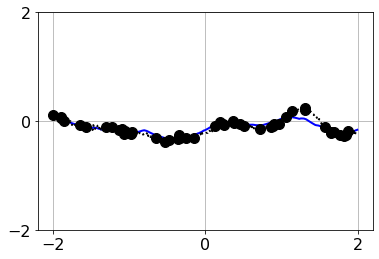

train:  96100 0.12983794510364532
train:  96200 0.159109964966774
train:  96300 0.2260238081216812
train:  96400 0.16478674113750458
train:  96500 0.04157481715083122
train:  96600 0.03390541672706604
train:  96700 0.01799151301383972
train:  96800 0.03784352168440819
train:  96900 0.009637486189603806
train:  97000 0.2070646584033966


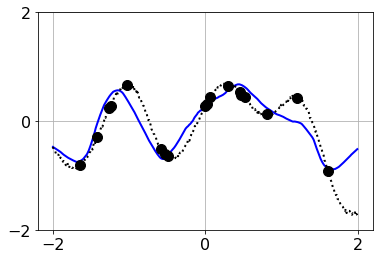

train:  97100 0.02950727380812168
train:  97200 0.0549372173845768
train:  97300 0.06937576085329056
train:  97400 0.06249673664569855
train:  97500 0.03486965224146843
train:  97600 0.03084663860499859
train:  97700 0.01786225661635399
train:  97800 0.0757138803601265
train:  97900 0.03666704520583153
train:  98000 0.026986069977283478


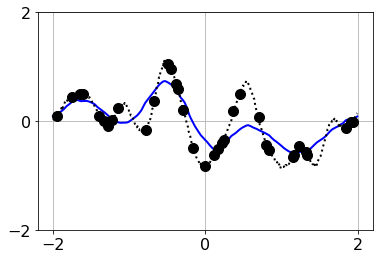

train:  98100 0.02152281440794468
train:  98200 0.154930979013443
train:  98300 0.036052677780389786
train:  98400 0.023994041606783867
train:  98500 0.02148178406059742
train:  98600 0.04609815776348114
train:  98700 0.04199179634451866
train:  98800 0.12772707641124725
train:  98900 0.1061343178153038
train:  99000 0.035708311945199966


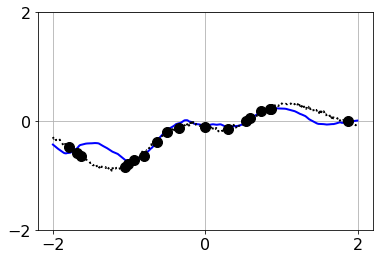

train:  99100 0.01973099820315838
train:  99200 0.03189432993531227
train:  99300 0.016998670995235443
train:  99400 0.015284977853298187
train:  99500 0.152566596865654
train:  99600 0.03570008650422096
train:  99700 0.04539376124739647
train:  99800 0.14408786594867706
train:  99900 0.04089079052209854


In [30]:
epochs = 100000
for epoch in range(epochs):
    model.train()
    data_train = dataset_train.generate_curves()
    (context_x, context_y), target_x = data_train.query
    target_y = data_train.target_y
    context_x = context_x.cuda()
    context_y = context_y.cuda()
    target_x = target_x.cuda()
    target_y = target_y.cuda()
    optim.zero_grad()
    y_pred, kl, loss, y_std = model(context_x, context_y, target_x, target_y)
    if epoch % 100 == 0:
        print("train: ", epoch, loss.item())
    loss.backward()
    optim.step()
    if epoch % 1000 == 0:
        model.eval()
        with torch.no_grad():
            data_test = dataset_test.generate_curves()
            (context_x, context_y), target_x = data_test.query
            target_y = data_test.target_y
            context_x = context_x.cuda()
            context_y = context_y.cuda()
            target_x = target_x.cuda()
            target_y = target_y.cuda()
            y_pred, kl, loss, y_std = model(context_x, context_y, target_x)
            plot_functions(target_x.detach().cpu().numpy(),
                           target_y.detach().cpu().numpy(),
                           context_x.detach().cpu().numpy(),
                           context_y.detach().cpu().numpy(),
                           y_pred.detach().cpu().numpy(),
                           y_std.detach().cpu().numpy())